#Detecting Hate Speech in Tweets

**Team:** Zuzanna Matysiak, Zachary Cahoone, Amy Zhou 

**Project Mentor TA:** Haoyu Wang

<font color='red'>TODO(all): Update the description of the project</font>

For our project, we will be investigating hate speech in tweets. We want to compare different machine learning models and see which one of them performs best in doing so and what features are based to extract to learn based on. We plan to use Natural Language Toolkit to tokenize Twitter data and extract features. The data we will be using will be similar to the data used in the paper that was the impetus for our project. Unfortunately, we do not have access to all 4 datasets that they used, hence we will use the available ones only: data from Davidson, data from Waseem, and we will send an email to Founta to ask for his data. Then, we will use select words that we believe could be indicators for hate speech to use as features. Initially, we will use the same bag of words they used. We will also do an investigation to see if there are other potentially predictive features we can include. We plan to use various machine learning models and compare their performance to the paper which only used logistic regression. We will evaluate our results by comparing to the f-1 score, precision and recall they got in our paper. If we can find models that can predict hate speech better, it is a good sign and we should discuss why that happened. If some models and feature extraction do not perform so well, we should perform case studies, try other features, and possibly discuss what are some reasons it went wrong. 

#### Possible add-ons to our project depending on the progress we have: using Twitter AAE model (similarly to what they did in the second part of the paper) to see if there is racial bias in classification of our models. This model takes in tweets and tells the probability they were written by black vs. white people based on the language used. We are a little skeptical about using this, as it adds more data inferred by models, but it is used in the cited paper. 

# Import libraries and datasets

#### In this section, we imported Davidson dataset and also bag of words of bad words. We tokonized tweets using TweetTokenizer from nltk. We also performed initial preprocessing of the data to add a column for each bad word from the bag.

In [2]:
import pandas as pd
from nltk.tokenize import TweetTokenizer
import csv
import urllib
import regex as re

In [3]:
!pip install sklearn

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In this part of the code, we will get our datasets. 

In [5]:
# Import Davidson dataset
url_hate_speech_data = "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv"
df_davidson = pd.read_csv(url_hate_speech_data)
df_davidson

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [6]:
# Import Waseem
df_waseem = pd.read_csv('/content/df_waseem_preprocessed.csv', sep=' ')
df_waseem

,Unnamed: 0,text,class_label
0,0,Drasko they didn't cook half a bird you idiot ...,racism
1,1,Hopefully someone cooks Drasko in the next ep ...,racism
2,3,of course you were born in serbia...you're as ...,racism
3,4,These girls are the equivalent of the irritati...,racism
4,5,RT @YesYoureRacist: At least you're only a tin...,racism
...,...,...,...
2738,2768,"RT @Superjutah: @MT8_9 £34,000 is £9000 above ...",sexism
2739,2769,RT @DufresneFrank: “@gabystama: @DufresneFrank...,sexism
2740,2770,RT @BoycottBrandy: @ActionFlickDoc this person...,sexism
2741,2771,RT @Lyall: Patriarchy™ will expel me if I divu...,sexism


In [ ]:
# TODO: import Founta dataset (Amy)

# Preprocessing of the data.
In this section we will explore various preprocessing methods of the data. 

This is a function that preprocesses the data in the following way: it drops the Unnamed:0 column, get rids of RT and mentiones in the data. 

In [7]:
def preprocessing_method1(df, col_name):
  df = df.drop(["Unnamed: 0"], axis = 1)
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(x))) # removes retweets
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'(@[A-Za-z0-9-_]+)', '', str(x))) # removes mentions
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'[^\w\s]','', str(x))) # remove punctuation
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'^\d+\s|\s\d+\s|\s\d+$', ' ', str(x))) # remove digits
  df[col_name] = df[col_name].apply(lambda x: re.sub(r'\s\s+', ' ', str(x))) # remove unncessary spaces
  return df

In [ ]:
# TODO (Amy) for whoever is doing preprocessing other methods, maybe separting hashtags into another column
# might help with better results :)

In [ ]:
# TODO: (Amy) also one type of preprocessing where data is barely preprocessed (so for 
# example we dont delete RTs, punctuation, etc), just an idea but might be cool to have a control set :) 

# Tokenizing  

We will define functions that will help us with tokenizng the data using TweetTokenizer(). 

In [8]:
def tokenize_method1(df, col_name):
   tweet_tokenizer = TweetTokenizer()
   df[col_name] = df[col_name].map(lambda x: tweet_tokenizer.tokenize(x))
   return df

In [9]:
def custom_tokenize(text): # For Waseem as it required special treatment for not string instances
  tweet_tokenizer = TweetTokenizer()
  if not(isinstance(text, str)):
    text = ''
  return tweet_tokenizer.tokenize(text)

In [ ]:
# TODO (Amy): add other tokenization methods

# Bag of words
In this section we will explore various bags of words. 

The first one we will use is the same one used in te original paper.

In [10]:
words = []
url_hate_words = "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/lexicons/refined_ngram_dict.csv"
bag_of_words = pd.read_csv(url_hate_words)
for i, row in bag_of_words.iterrows():
  words.append(row[0])

A function to modify dataframe to account for the bag of words.

In [11]:
def add_bad_words(df, label):
  for word in words:
    df[word] = df[label].map(lambda x: 1 if word in x else 0)

In [ ]:
# TODO (Amy): add other bags of words 

In [ ]:
# TODO (Zach): use hatebase as bag of words

# Getting the datasets ready for training using first method of preprocessing
We will start with preprocessing the Davidson dataset. 

In [12]:
df_davidson = preprocessing_method1(df_davidson, "tweet")
df_davidson

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,As a woman you shouldnt complain about cleani...
1,3,0,3,0,1,boy dats coldtyga dwn bad for cuffin dat hoe ...
2,3,0,3,0,1,Dawg RT You ever fuck a bitch and she start t...
3,3,0,2,1,1,she look like a tranny
4,6,0,6,0,1,The shit you hear about me might be true or i...
...,...,...,...,...,...,...
24778,3,0,2,1,1,yous a muthafin lie right His TL is trash Now ...
24779,3,0,1,2,2,youve gone and broke the wrong heart baby and ...
24780,3,0,3,0,1,young buck wanna eat dat nigguh like I aint fu...
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [13]:
df_davidson = tokenize_method1(df_davidson, "tweet")

In [14]:
add_bad_words(df_davidson, "tweet")
df_davidson

,count,hate_speech,offensive_language,neither,class,tweet,allah akbar,blacks,chink,chinks,dykes,faggot,faggots,fags,homo,inbred,nigger,niggers,queers,raped,savages,slave,spic,wetback,wetbacks,whites,a dirty,a nigger,all niggers,all white,always fuck,ass white,be killed,beat him,biggest faggot,blame the,butt ugly,chink eyed,chinks in,coon shit,...,is a faggot,is a fuckin,is a fucking,is a nigger,like a faggot,like da colored,many niggers are,nigga and his,niggers are in,of white trash,shut up nigger,still a faggot,the biggest faggot,the faggots who,the fuck do,they all look,what a fag,white bitch in,white trash and,you a fag,you a lame,you a nigger,you fuck wit,you fucking faggot,your a cunt,your a dirty,your bitch in,a bitch made nigga,a lame nigga you,faggot if you ever,full of white trash,how many niggers are,is full of white,lame nigga you a,many niggers are in,nigga you a lame,niggers are in my,wit a lame nigga,you a lame bitch,you fuck wit a
0,3,0,0,3,2,"[As, a, woman, you, shouldnt, complain, about,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,0,3,0,1,"[boy, dats, coldtyga, dwn, bad, for, cuffin, d...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,3,0,1,"[Dawg, RT, You, ever, fuck, a, bitch, and, she...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,2,1,1,"[she, look, like, a, tranny]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,0,6,0,1,"[The, shit, you, hear, about, me, might, be, t...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,3,0,2,1,1,"[yous, a, muthafin, lie, right, His, TL, is, t...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24779,3,0,1,2,2,"[youve, gone, and, broke, the, wrong, heart, b...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24780,3,0,3,0,1,"[young, buck, wanna, eat, dat, nigguh, like, I...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24781,6,0,6,0,1,"[youu, got, wild, bitches, tellin, you, lies]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# Defining which classes we will be dropping when testing
labels_davidson = ["count", "hate_speech", "offensive_language", "neither", "class", "tweet"]
label_davidson = "class"

Let's do some word frequency distribution analysis to see the relation between our Davidson dataset and bag of words that we just used. 

In [16]:
# Get bad words from the tweets to see their frequency distribution 
def get_bad_words(df, l):
  count_of_words = df[l].sum()
  count_of_words = [x for x in count_of_words if x in words]
  return count_of_words

In [18]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
# plot histogram of bad words in the specified dataset
def plot_bad_words_histogram(count_of_words):
  counts = Counter(count_of_words)
  labels, values = zip(*counts.items())
  indices = np.arange(len(labels))
  bar_width = 0.2
  plt.bar(indices, values)
  plt.xticks(indices + bar_width, labels, rotation="vertical")
  plt.title("Bad words frequency in Davidson dataset tweets overall")
  plt.show()

In [19]:
davidson_count_of_words = get_bad_words(df_davidson, "tweet")
print(davidson_count_of_words[:30])

['faggots', 'faggot', 'faggot', 'faggot', 'niggers', 'nigger', 'niggers', 'faggot', 'fags', 'faggot', 'faggot', 'nigger', 'faggot', 'niggers', 'faggot', 'nigger', 'faggot', 'dykes', 'nigger', 'faggot', 'niggers', 'faggots', 'fags', 'faggot', 'faggot', 'faggots', 'faggot', 'niggers', 'spic', 'spic']


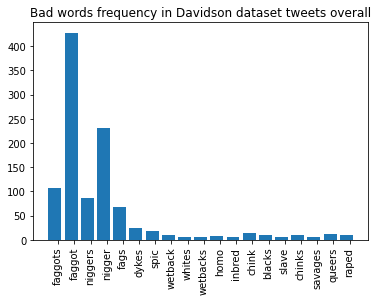

In [20]:
plot_bad_words_histogram(davidson_count_of_words)

We will also use WordCloud to get a better sense of the preprocessed dataset's mostly frequently used words.

In [21]:
from wordcloud import WordCloud
def generate_word_cloud(count_of_words):
  wordcloud = WordCloud(max_font_size=50, background_color="white", collocations=False).generate(' '.join(count_of_words))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

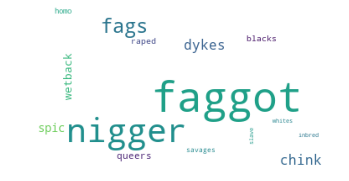

In [22]:
generate_word_cloud(davidson_count_of_words)

Now, we will get Waseem dataset ready to go. Some additional preprocessing as opposed to Davidson is needed because it is possible to have some NaNs still that we want to fill with "none".

In [23]:
df_waseem = preprocessing_method1(df_waseem, "text")
df_waseem["text"].dropna(inplace=True)
df_waseem["text"] = df_waseem["text"].map(lambda x: custom_tokenize(x)) # needed custom tokenizing due some strange errors with colab
df_waseem["class_label"] = df_waseem['class_label'].fillna("none")

# Defining which classes we will be dropping when testing
labels_waseem = ["class_label", "text"] # crucial to include text here
label_waseem = "class_label"
df_waseem

,text,class_label
0,"[Drasko, they, didnt, cook, half, a, bird, you...",racism
1,"[Hopefully, someone, cooks, Drasko, in, the, n...",racism
2,"[of, course, you, were, born, in, serbiayoure,...",racism
3,"[These, girls, are, the, equivalent, of, the, ...",racism
4,"[At, least, youre, only, a, tiny, bit, racist,...",racism
...,...,...
2738,"[is, above, the, national, average, wage, PLUS...",sexism
2739,"[its, a, great, website, use, it, omg, you, ar...",sexism
2740,"[this, person, thinks, there, is, no, wage, ga...",sexism
2741,"[Patriarchy, will, expel, me, if, I, divulge, ...",sexism


Changing the class name column to numbers, 0 - racism, 1 - sexism, 2 - none

In [24]:
df_waseem['class_label'].loc[(df_waseem['class_label'] == "racism")] = 0
df_waseem['class_label'].loc[(df_waseem['class_label'] == "sexism")] = 1
df_waseem['class_label'].loc[(df_waseem['class_label'] == "none")] = 2
df_waseem

,text,class_label
0,"[Drasko, they, didnt, cook, half, a, bird, you...",0
1,"[Hopefully, someone, cooks, Drasko, in, the, n...",0
2,"[of, course, you, were, born, in, serbiayoure,...",0
3,"[These, girls, are, the, equivalent, of, the, ...",0
4,"[At, least, youre, only, a, tiny, bit, racist,...",0
...,...,...
2738,"[is, above, the, national, average, wage, PLUS...",1
2739,"[its, a, great, website, use, it, omg, you, ar...",1
2740,"[this, person, thinks, there, is, no, wage, ga...",1
2741,"[Patriarchy, will, expel, me, if, I, divulge, ...",1


Shuffle the dataset so that all 0s and 1s are not next to each other (crucial for training).

In [25]:
df_waseem = df_waseem.sample(frac = 1)
df_waseem

,text,class_label
2448,"[we, are, in, America, Its, american, women, t...",1
2283,"[Im, not, sexist, but, I, hate, female, sports...",2
920,"[Just, going, to, keep, this, here, so, I, can...",1
1621,"[Nope, Call, me, sexist, but, No, Shave, Novem...",2
2588,"[Im, not, sexist, but, I, hate, female, sport,...",1
...,...,...
963,"[OK, w, reasonable, burping, Sneezing, is, inv...",2
690,"[Get, a, girl, pregnant, and, find, out]",2
1673,"[The, people, at, work, are, childish, Lol, it...",2
970,[Proof],1


In [26]:
add_bad_words(df_waseem, "text")
df_waseem

,text,class_label,allah akbar,blacks,chink,chinks,dykes,faggot,faggots,fags,homo,inbred,nigger,niggers,queers,raped,savages,slave,spic,wetback,wetbacks,whites,a dirty,a nigger,all niggers,all white,always fuck,ass white,be killed,beat him,biggest faggot,blame the,butt ugly,chink eyed,chinks in,coon shit,dumb monkey,dumb nigger,fag and,fag but,...,is a faggot,is a fuckin,is a fucking,is a nigger,like a faggot,like da colored,many niggers are,nigga and his,niggers are in,of white trash,shut up nigger,still a faggot,the biggest faggot,the faggots who,the fuck do,they all look,what a fag,white bitch in,white trash and,you a fag,you a lame,you a nigger,you fuck wit,you fucking faggot,your a cunt,your a dirty,your bitch in,a bitch made nigga,a lame nigga you,faggot if you ever,full of white trash,how many niggers are,is full of white,lame nigga you a,many niggers are in,nigga you a lame,niggers are in my,wit a lame nigga,you a lame bitch,you fuck wit a
2448,"[we, are, in, America, Its, american, women, t...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2283,"[Im, not, sexist, but, I, hate, female, sports...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
920,"[Just, going, to, keep, this, here, so, I, can...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1621,"[Nope, Call, me, sexist, but, No, Shave, Novem...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2588,"[Im, not, sexist, but, I, hate, female, sport,...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,"[OK, w, reasonable, burping, Sneezing, is, inv...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
690,"[Get, a, girl, pregnant, and, find, out]",2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1673,"[The, people, at, work, are, childish, Lol, it...",2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
970,[Proof],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's try to better understand the relationship between the dataset and the bag of words.

In [27]:
waseem_count_of_words = get_bad_words(df_waseem, "text")
print(waseem_count_of_words[:30])

['raped', 'raped', 'raped', 'raped', 'faggots', 'raped', 'faggot', 'raped', 'raped', 'raped']


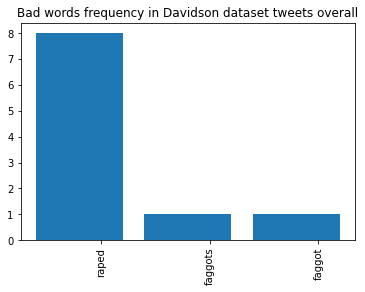

In [28]:
plot_bad_words_histogram(waseem_count_of_words)

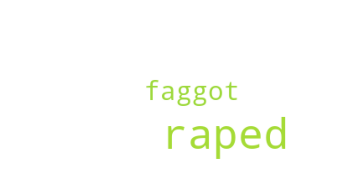

In [29]:
generate_word_cloud(waseem_count_of_words)

In [ ]:
# TODO (Amy): preprocess data in other ways + preproces Founta data 
# when adding new methods of preprocessing remember to run it on all datasets that we have 

In [ ]:
# TODO (Zach): after adding Hate base as bag of words, preprocess the data and also run the models on it later 

#Models
In this section, we will initialize model functions that we will later use to see which Machine Learning Model performs best for the task of hate speech detection. 

In [ ]:
# TODO (all): right now all the models are running for all labels simultaneously
# for example it is assigning sexism, racism, none at the same time
# in the paper, they do it separetly. Hence we should keep what we have but
# we should also have the separation 
# Bottom line: DO NOT DELETE THE CODE FOR THEM at once but rather also
# add the code for all 2 separately for each dataset
# TODO(Zuzanna): Waseem & Davidson
# TODO(Amy): Founta
# Remember, this step will include also adding the code to the later section, make
# sure it is also added there.

## Decision Tree Classifier

#### In this section we define Decision Tree Classifier. We used max_depth to be 10 and min_samples_leaf to be 5. 

In [30]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree_classifier(dataset, labels, label):
  X_train, X_test, y_train, y_test = train_test_split(dataset.drop(labels, axis = 1), dataset[label].astype(int), test_size = 0.3)
  clf = DecisionTreeClassifier(random_state = 100, max_depth = 10, min_samples_leaf = 5)
  clf.fit(X_train, y_train)
  decision_tree_preds = clf.predict(X_test)
  y_test_decision = y_test
  return precision_recall_fscore_support(y_test, decision_tree_preds)

## Adabooost Classifier

#### Here, we trained yet another classifier– Adaboost. 

In [31]:
from sklearn.ensemble import AdaBoostClassifier
def adaboost_classifier(df, labels, label):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(labels, axis = 1), df[label].astype(int), test_size = 0.3)
  clf = AdaBoostClassifier()
  clf.fit(X_train, y_train)
  adaboost_preds = clf.predict(X_test)
  y_test_adaboost = y_test
  return precision_recall_fscore_support(y_test, adaboost_preds)

## Logistic Regression

#### Third model we used is the same model as they used in the study— logisitic regression. 

In [32]:
from sklearn.linear_model import LogisticRegression

def logisitic_regression_classifier(df, labels, label):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(labels, axis = 1), df[label].astype(int), test_size = 0.3)

  clf = LogisticRegression()
  clf.fit(X_train, y_train)

  logistic_preds = clf.predict(X_test)
  y_test_logisitic = y_test
  return precision_recall_fscore_support(y_test, logistic_preds)

## Linear Regression
Here we will explore linear regression. We will use MSE, R2 score, and RMSE to assess our results because we cannot use precision, accuracy, and recall for Linear Regression.

In [33]:
from sklearn.linear_model import LinearRegression

def linear_regression_classifier(df, labels, label):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(labels, axis = 1), df[label].astype(int), test_size = 0.3)

  clf = LinearRegression()
  clf.fit(X_train, y_train)

  lin_preds = clf.predict(X_test)
  y_test_lin = y_test
  return [mean_squared_error(y_test_lin, lin_preds), r2_score(y_test_lin, lin_preds), 
          mean_squared_error(y_test_lin, lin_preds, squared=False)] # in order MSE, R2, RMSE

## Random Forest
In this part we will create **Random Forest** Classifier with usage of **gini** index. 

In [36]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier_gini(df, labels, label):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(labels, axis = 1), df[label].astype(int), test_size = 0.3)

  clf = RandomForestClassifier()
  clf.fit(X_train, y_train)

  random_forest_preds = clf.predict(X_test)
  y_test_rf = y_test
  return precision_recall_fscore_support(y_test, random_forest_preds)

And now with usage of **entropy**. 

In [37]:
def random_forest_classifier_entropy(df, labels, label):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(labels, axis = 1), df[label].astype(int), test_size = 0.3)

  clf = RandomForestClassifier(criterion="entropy")
  clf.fit(X_train, y_train)

  random_forest_preds = clf.predict(X_test)
  y_test_rf = y_test
  return precision_recall_fscore_support(y_test, random_forest_preds)

In [ ]:
# TODO (Zuzanna): add CNNs (different variations and combinations)

In [ ]:
# TODO (Zuzanna): add k means (for at least 2 different values of k)
# TODO (Zuzanna): look at possible parameter tweaks

In [ ]:
# TODO (Amy): add k nearest neighbors (for at least 2 different values of k)

# Running the models on the data
In this section, we will use functions defined above to run them on the preprocessed data. 

First, we will run our data on the **Decision Tree Classifier**. We start with **Davidson data**. 

In [68]:
decision_tree_metrics_davidson = decision_tree_classifier(df_davidson, labels_davidson, label_davidson)
decision_tree_metrics_davidson

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.52747253, 0.77913943, 0.        ]),
 array([0.11294118, 0.99271339, 0.        ]),
 array([0.18604651, 0.87305462, 0.        ]),
 array([ 425, 5764, 1246]))

Then we run it on the **Waseem data.** 

In [69]:
decision_tree_metrics_waseem = decision_tree_classifier(df_waseem, labels_waseem, label_waseem)
decision_tree_metrics_waseem

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.        , 0.70595383, 0.        ]),
 array([0., 1., 0.]),
 array([0.        , 0.82763533, 0.        ]),
 array([  3, 581, 239]))

Next, we will use **Adaboost**. We will yet again start with Davidson dataset. 

In [58]:
adaboost_metrics_davidson = adaboost_classifier(df_davidson, labels_davidson, label_davidson)
adaboost_metrics_davidson

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.54794521, 0.77940777, 0.        ]),
 array([0.09546539, 0.99462645, 0.        ]),
 array([0.16260163, 0.87396238, 0.        ]),
 array([ 419, 5769, 1247]))

Next, **Waseem**.

In [59]:
adaboost_metrics_waseem = adaboost_classifier(df_waseem, labels_waseem, label_waseem)
adaboost_metrics_waseem

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.        , 0.68658537, 0.33333333]),
 array([0.        , 0.99646018, 0.00393701]),
 array([0.        , 0.81299639, 0.0077821 ]),
 array([  4, 565, 254]))

Next, we will use **Logistic Regression** similarly to to what they did in the paper. We will start with **Davidson** data. 

In [60]:
log_reg_metrics_davidson = logisitic_regression_classifier(df_davidson, labels_davidson, label_davidson)
log_reg_metrics_davidson

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.56756757, 0.77095503, 0.        ]),
 array([0.09438202, 0.99439285, 0.        ]),
 array([0.16184971, 0.86853382, 0.        ]),
 array([ 445, 5707, 1283]))

And **Waseem**:

In [61]:
log_reg_metrics_waseem = logisitic_regression_classifier(df_waseem, labels_waseem, label_waseem)
log_reg_metrics_waseem

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.        , 0.69258809, 0.        ]),
 array([0., 1., 0.]),
 array([0.       , 0.8183776, 0.       ]),
 array([  5, 570, 248]))

Now we will train the models using **Linear Regression**. We will start with the **Davidson** dataset. Remember that metrics for Logistic Regression that we used are MSE, R2 score and RMSE.

In [82]:
lin_reg_metrics_davidson = linear_regression_classifier(df_davidson, labels_davidson, label_davidson)
lin_reg_metrics_davidson

[0.1971853513191478, 0.06830981634375533, 0.4440555723320537]

And now on **Waseem** dataset. 

In [83]:
lin_reg_metrics_waseem = linear_regression_classifier(df_waseem, labels_waseem, label_waseem)
lin_reg_metrics_waseem

[0.21974625032219097, -0.002117528139714997, 0.46877099987327603]

Next we will explore usage of **Random Forests** using **gini** index starting with **Davidson** dataset. 

In [39]:
rf_gini_metrics_davidson = random_forest_classifier_gini(df_davidson, labels_davidson, label_davidson)
rf_gini_metrics_davidson

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.63218391, 0.77885139, 0.        ]),
 array([0.12910798, 0.99443962, 0.        ]),
 array([0.21442495, 0.87354041, 0.        ]),
 array([ 426, 5755, 1254]))

... and now using **entropy**. 

In [40]:
rf_entropy_metrics_davidson = random_forest_classifier_entropy(df_davidson, labels_davidson, label_davidson)
rf_entropy_metrics_davidson

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.57333333, 0.77839674, 0.        ]),
 array([0.10046729, 0.99461806, 0.        ]),
 array([0.17097416, 0.87332317, 0.        ]),
 array([ 428, 5760, 1247]))

We will proceed to do the same on the **Waseem** dataset now starting out with using **Random Forest**, **gini** index criterion method. 

In [41]:
rf_gini_metrics_waseem = random_forest_classifier_gini(df_waseem, labels_waseem, label_waseem)
rf_gini_metrics_waseem

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.        , 0.72417983, 0.        ]),
 array([0., 1., 0.]),
 array([0.        , 0.84002819, 0.        ]),
 array([  4, 596, 223]))

... and now **entropy**.

In [42]:
rf_entropy_metrics_waseem = random_forest_classifier_entropy(df_waseem, labels_waseem, label_waseem)
rf_entropy_metrics_waseem

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.        , 0.69623329, 0.        ]),
 array([0., 1., 0.]),
 array([0.        , 0.82091691, 0.        ]),
 array([  5, 573, 245]))

In [ ]:
# TODO (all): talk on why it has no chance to work well on Waseem because of the bag of words vs dataset relationship here.

In [ ]:
# TODO (all): remember to update this section after you add new models above / preprocess data differently 

# Confusion Matrices & Heatmaps

#### confusion_matrix_func takes in y_true, y_predicted, label names and model name and displays confusion matrix for given predictions. We ran that function on all of the predictions made in order to visualize how our predictions are doing for different models in comparison to each other. 

In [62]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confusion_matrix_func(y_true, y_predicted, labels, model_name_title, figsize = (10,10)):
    cm = confusion_matrix(y_true, y_predicted)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot = cm)
    plt.title(model_name_title)
    plt.show()

In [ ]:
# TODO (Zuzanna): fix this
labels_for_cm = ["hate_speech", "offensive_language", "neither"]
confusion_matrix_func(y_test_decision, decision_tree_preds, labels_for_cm, "Confusion matrix for decision tree:")

NameError: ignored

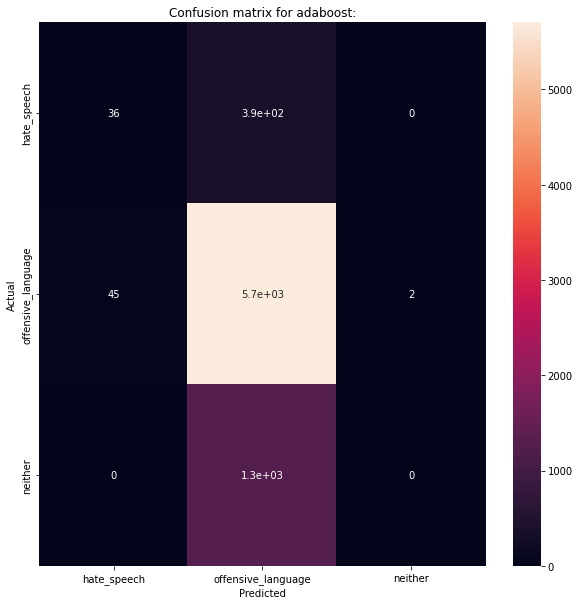

In [ ]:
confusion_matrix_func(y_test_adaboost, adaboost_preds, labels_for_cm, "Confusion matrix for adaboost:")

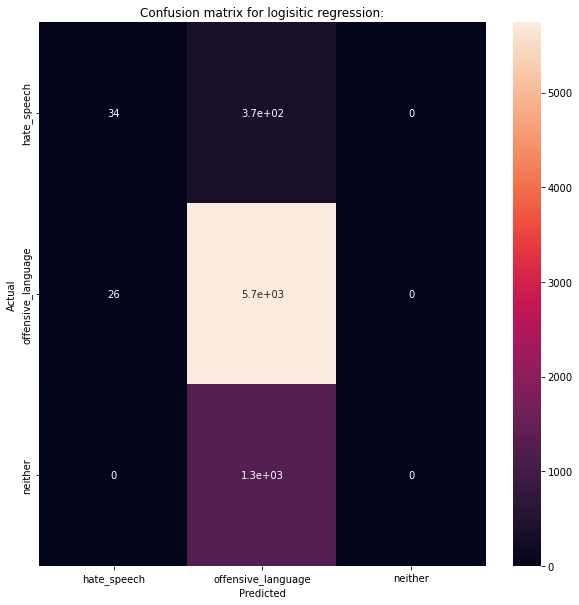

In [ ]:
confusion_matrix_func(y_test_logisitic, logistic_preds, labels_for_cm, "Confusion matrix for logisitic regression:")

# Data Analysis of the Results 

In [ ]:
# TODO (Zach): data analysis of the results

In [ ]:
# TODO (Zach): BERT in AWS (probably not in this notebook, add it separately on github but
# include results in data analysis section on github)

In [ ]:
# TODO (Zuzanna): Twitter AAE 